# CSC 180 - Project 1
### Contributors: *Anish Chouhan, Austin Melendez, Daniel Nishi, Brian Hert*

### Useful Functions

In [1]:
# Written by Dr. Haiquan Chen

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
    
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


## Preprocessing

### File Processing

Reading the business data from Yelp's json file and filtering out businesses with less then 20 reviews

In [2]:
import pandas as pd
#from google.colab import drive
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('/content/drive/My Drive/180 project 1')



df_business = df_business.filter(['business_id', 'stars', 'review_count', 'name'])
df_business = df_business[df_business['review_count'] >= 20]
print(df_business.shape)
df_business.head()



(61919, 4)


,business_id,stars,review_count,name
2,tUFrWirKiKi_TAnsVWINQQ,3.5,22,Target
3,MTSW4McQd7CbVtyjqoe9mw,4.0,80,St Honore Pastries
12,il_Ro8jwPlHresjw9EGmBg,2.5,28,Denny's
14,0bPLkL0QhhPO5kt1_EXmNQ,4.5,100,Zio's Italian Market
15,MUTTqe8uqyMdBl186RmNeA,4.0,245,Tuna Bar


Reading the review data from Yelp's json file.

In [3]:
import pandas as pd

#import os
#os.chdir('/content/drive/My Drive/180 project 1')

df_review = pd.read_json('./data/yelp_academic_dataset_review.json', lines=True, nrows = 1000000)

print(df_review.shape)
df_review.head()


(1000000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


Merged businesses and reviews.

In [4]:
df_review_agg = df_review.groupby('business_id')['text'].sum()
funny = df_review.groupby('business_id')['funny'].sum()
useful = df_review.groupby('business_id')['useful'].sum()
cool = df_review.groupby('business_id')['cool'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,'all_reviews': df_review_agg.values,'useful': useful.values ,'funny': funny.values, 'cool': cool.values})
df_review_merged = pd.merge(df_ready_to_be_sent_to_sklearn, df_business, on='business_id')
print(df_review_merged.shape)
df_review_merged.head()

(11927, 8)


,business_id,all_reviews,useful,funny,cool,stars,review_count,name
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,48,22,35,4.5,32,Chris's Sandwich Shop
1,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...,1,0,2,4.0,29,Philadelphia
2,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,90,8,15,4.5,109,Family Vision Center
3,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,8,5,2,4.5,34,Washoe Metal Fabricating
4,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,0,0,0,4.0,25,Stewart's De Rooting & Plumbing


Normalize numerical values based on min/max. (This provided worse results, we will use z-score normalization)

In [5]:
#encode_numeric_range(df_review_merged,'review_count')
#encode_numeric_range(df_review_merged,'funny')
#encode_numeric_range(df_review_merged,'useful')
#encode_numeric_range(df_review_merged, 'cool')
#print(df_review_merged.shape)
#df_review_merged.head()

Normalize numeric values based on z-scores provided better overall results for the below models.

In [6]:
encode_numeric_zscore(df_review_merged,'review_count')
encode_numeric_zscore(df_review_merged,'funny')
encode_numeric_zscore(df_review_merged,'useful')
encode_numeric_zscore(df_review_merged, 'cool')
print(df_review_merged.shape)
df_review_merged.head()

(11927, 8)


,business_id,all_reviews,useful,funny,cool,stars,review_count,name
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,-0.213302,-0.013789,0.011088,4.5,-0.396133,Chris's Sandwich Shop
1,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...,-0.528041,-0.451885,-0.424567,4.0,-0.414095,Philadelphia
2,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,0.067954,-0.292578,-0.252946,4.5,0.064880,Family Vision Center
3,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,-0.481165,-0.352318,-0.424567,4.5,-0.384159,Washoe Metal Fabricating
4,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,-0.534737,-0.451885,-0.450970,4.0,-0.438043,Stewart's De Rooting & Plumbing


## TF-IDF Matrices

Create different tf-idf matrices with different maximum feature words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_500 = TfidfVectorizer( max_features= 500,stop_words= 'english', min_df=1)
v_1000 = TfidfVectorizer( max_features= 1000,stop_words= 'english', min_df=1)
v_1500 = TfidfVectorizer( max_features= 1500,stop_words= 'english', min_df=1)

matrix_500 = v_500.fit_transform(df_review_merged['all_reviews'])
matrix_1000 = v_1000.fit_transform(df_review_merged['all_reviews'])
matrix_1500 = v_1500.fit_transform(df_review_merged['all_reviews'])

### Testing 500 feature words

In [59]:
from sklearn.model_selection import train_test_split

featured_names = v_500.get_feature_names_out()

x_data = matrix_500.toarray()
print(x_data)
print(featured_names)

x = x_data
y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

[[0.         0.         0.         ... 0.01580098 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0053805  0.03197492 0.042989   ... 0.03536421 0.00676511 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03936097 0.         0.         ... 0.02069652 0.         0.03580244]
 [0.         0.         0.         ... 0.04504372 0.         0.        ]]
['10' '15' '20' '30' '50' 'able' 'absolutely' 'actually' 'add' 'ago'
 'amazing' 'ambiance' 'appetizer' 'area' 'arrived' 'ask' 'asked' 'ate'
 'atmosphere' 'attentive' 'authentic' 'available' 'average' 'away'
 'awesome' 'bacon' 'bad' 'bar' 'bartender' 'bbq' 'beans' 'beautiful'
 'beef' 'beer' 'beers' 'believe' 'best' 'better' 'big' 'birthday' 'bit'
 'bite' 'bowl' 'boyfriend' 'bread' 'breakfast' 'bring' 'brought' 'brunch'
 'burger' 'burgers' 'business' 'busy' 'butter' 'buy' 'cake' 'called'
 'came' 'car' 'care' 'change' 'charge' 'cheap' 'check' 'cheese' '

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('./dnn/best_weights.keras')

pred = model.predict(x_test)

score_500 = np.sqrt(metrics.mean_squared_error(pred, y_test))

Epoch 1/1000


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 - 1s - 7ms/step - loss: 1.7538 - val_loss: 0.6481
Epoch 2/1000
75/75 - 0s - 2ms/step - loss: 0.5916 - val_loss: 0.5584
Epoch 3/1000
75/75 - 0s - 2ms/step - loss: 0.5010 - val_loss: 0.4735
Epoch 4/1000
75/75 - 0s - 2ms/step - loss: 0.4198 - val_loss: 0.3986
Epoch 5/1000
75/75 - 0s - 2ms/step - loss: 0.3523 - val_loss: 0.3422
Epoch 6/1000
75/75 - 0s - 2ms/step - loss: 0.3033 - val_loss: 0.3036
Epoch 7/1000
75/75 - 0s - 2ms/step - loss: 0.2713 - val_loss: 0.2821
Epoch 8/1000
75/75 - 0s - 2ms/step - loss: 0.2524 - val_loss: 0.2744
Epoch 9/1000
75/75 - 0s - 2ms/step - loss: 0.2408 - val_loss: 0.2606
Epoch 10/1000
75/75 - 0s - 2ms/step - loss: 0.2327 - val_loss: 0.2537
Epoch 11/1000
75/75 - 0s - 2ms/step - loss: 0.2273 - val_loss: 0.2515
Epoch 12/1000
75/75 - 0s - 2ms/step - loss: 0.2225 - val_loss: 0.2460
Epoch 13/1000
75/75 - 0s - 2ms/step - loss: 0.2190 - val_loss: 0.2432
Epoch 14/1000
75/75 - 0s - 2ms/step - loss: 0.2155 - val_loss: 0.2394
Epoch 15/1000
75/75 - 0s - 2ms/step - loss

### Testing 1000 feature words


In [61]:
featured_names = v_1000.get_feature_names_out()

x_data = matrix_1000.toarray()
print(x_data)
print(featured_names)

x = x_data
y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

[[0.01703163 0.         0.         ... 0.         0.04169674 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00297757 0.01861302 ... 0.00444197 0.         0.        ]
 ...
 [0.06741645 0.         0.         ... 0.         0.         0.        ]
 [0.         0.03405764 0.         ... 0.03048457 0.         0.03097857]
 [0.         0.         0.         ... 0.03764996 0.         0.        ]]
['00' '10' '100' '11' '12' '15' '20' '25' '30' '40' '45' '50' 'able'
 'absolutely' 'accommodating' 'actually' 'add' 'added' 'addition'
 'affordable' 'afternoon' 'ago' 'ahead' 'air' 'amazing' 'ambiance'
 'american' 'apparently' 'appetizer' 'appetizers' 'apple' 'appointment'
 'appreciate' 'area' 'aren' 'arrived' 'art' 'asian' 'ask' 'asked' 'asking'
 'ate' 'atmosphere' 'attention' 'attentive' 'attitude' 'authentic'
 'available' 'average' 'avocado' 'avoid' 'away' 'awesome' 'awful' 'bacon'
 'bad' 'bag' 'baked' 'bakery' 'bar' 'barbara' 'barely' 'bars' 'bar

In [62]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('./dnn/best_weights.keras')

pred = model.predict(x_test)

score_1000 = np.sqrt(metrics.mean_squared_error(pred, y_test))

Epoch 1/1000


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 - 1s - 8ms/step - loss: 2.4856 - val_loss: 0.6831
Epoch 2/1000
75/75 - 0s - 2ms/step - loss: 0.6476 - val_loss: 0.6261
Epoch 3/1000
75/75 - 0s - 2ms/step - loss: 0.5870 - val_loss: 0.5678
Epoch 4/1000
75/75 - 0s - 2ms/step - loss: 0.5232 - val_loss: 0.5020
Epoch 5/1000
75/75 - 0s - 2ms/step - loss: 0.4580 - val_loss: 0.4384
Epoch 6/1000
75/75 - 0s - 3ms/step - loss: 0.3915 - val_loss: 0.3722
Epoch 7/1000
75/75 - 0s - 2ms/step - loss: 0.3328 - val_loss: 0.3245
Epoch 8/1000
75/75 - 0s - 2ms/step - loss: 0.2893 - val_loss: 0.2899
Epoch 9/1000
75/75 - 0s - 2ms/step - loss: 0.2599 - val_loss: 0.2677
Epoch 10/1000
75/75 - 0s - 2ms/step - loss: 0.2410 - val_loss: 0.2542
Epoch 11/1000
75/75 - 0s - 2ms/step - loss: 0.2286 - val_loss: 0.2459
Epoch 12/1000
75/75 - 0s - 2ms/step - loss: 0.2196 - val_loss: 0.2404
Epoch 13/1000
75/75 - 0s - 2ms/step - loss: 0.2131 - val_loss: 0.2353
Epoch 14/1000
75/75 - 0s - 2ms/step - loss: 0.2076 - val_loss: 0.2305
Epoch 15/1000
75/75 - 0s - 2ms/step - loss

### Testing 1500 feature words

In [63]:
featured_names = v_1500.get_feature_names_out()

x_data = matrix_1500.toarray()
print(x_data)
print(featured_names)

x = x_data
y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

[[0.01607719 0.         0.         ... 0.03936009 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00286787 0.0179273  ... 0.         0.         0.        ]
 ...
 [0.04624286 0.         0.         ... 0.         0.         0.01412062]
 [0.         0.03299562 0.         ... 0.         0.03001257 0.02396271]
 [0.         0.         0.         ... 0.         0.         0.        ]]
['00' '10' '100' ... 'yum' 'yummy' 'zero']


In [64]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('./dnn/best_weights.keras')

pred = model.predict(x_test)

score_1500 = np.sqrt(metrics.mean_squared_error(pred, y_test))

Epoch 1/1000


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 - 1s - 7ms/step - loss: 1.4795 - val_loss: 0.6449
Epoch 2/1000
75/75 - 0s - 2ms/step - loss: 0.5974 - val_loss: 0.5663
Epoch 3/1000
75/75 - 0s - 2ms/step - loss: 0.5169 - val_loss: 0.4888
Epoch 4/1000
75/75 - 0s - 2ms/step - loss: 0.4411 - val_loss: 0.4191
Epoch 5/1000
75/75 - 0s - 2ms/step - loss: 0.3738 - val_loss: 0.3621
Epoch 6/1000
75/75 - 0s - 2ms/step - loss: 0.3197 - val_loss: 0.3173
Epoch 7/1000
75/75 - 0s - 2ms/step - loss: 0.2811 - val_loss: 0.2880
Epoch 8/1000
75/75 - 0s - 2ms/step - loss: 0.2546 - val_loss: 0.2677
Epoch 9/1000
75/75 - 0s - 2ms/step - loss: 0.2371 - val_loss: 0.2549
Epoch 10/1000
75/75 - 0s - 2ms/step - loss: 0.2259 - val_loss: 0.2463
Epoch 11/1000
75/75 - 0s - 2ms/step - loss: 0.2168 - val_loss: 0.2409
Epoch 12/1000
75/75 - 0s - 2ms/step - loss: 0.2102 - val_loss: 0.2347
Epoch 13/1000
75/75 - 0s - 2ms/step - loss: 0.2044 - val_loss: 0.2299
Epoch 14/1000
75/75 - 0s - 2ms/step - loss: 0.2000 - val_loss: 0.2275
Epoch 15/1000
75/75 - 0s - 2ms/step - loss

## Results

In [65]:
print("Final score (RMSE) when max_feature=500:\t{}".format(score_500))
print("Final score (RMSE) when max_feature=1000:\t{}".format(score_1000))
print("Final score (RMSE) when max_feature=1500:\t{}".format(score_1500))

Final score (RMSE) when max_feature=500:	0.456576740512365
Final score (RMSE) when max_feature=1000:	0.44222087847346037
Final score (RMSE) when max_feature=1500:	0.4389867059411673


TF-IDF using 1500 feature words has the best RMSE score, therefore we will use that matrix when tuning our hyperparameters.

In [66]:
featured_names = v_1500.get_feature_names_out()

x_data = matrix_1500.toarray()

x = x_data
y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Hyperparameter Tuning

## Testing Activation Functions

### Model #1 (3 Layers, sigmoid Activation, sgd Optimizer)

Since we've already tested the ReLU activation function, lets test using the sigmoid or tanh functions instead.

In [67]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(10, activation='sigmoid')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 1s - 2ms/step - loss: 1.1500 - val_loss: 0.7068
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.6899 - val_loss: 0.7052
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.6894 - val_loss: 0.7032
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.6888 - val_loss: 0.7028
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.6881 - val_loss: 0.7100
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.6876 - val_loss: 0.7045
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.6868 - val_loss: 0.7047
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.6862 - val_loss: 0.6996
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.6850 - val_loss: 0.6989
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.6838 - val_loss: 0.7008
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.6828 - val_loss: 0.6995
Epoch 12/100
299/299 - 0s - 1ms/step - loss: 0.6820 - val_loss: 0.6973
Epoch 13/100
299/299 - 0s - 1ms/step - loss: 0.6804 - val_loss: 0.6979
Epoch 14/100
299/299 - 0s - 1ms/step - loss: 0.6786 - val_loss: 0.6924
Epoch 15/100
299/299 - 0s -

In [68]:
pred = model.predict(x_test)

score1 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #2 (3 Layers, tanh Activation, sgd Optimizer)

In [69]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 1s - 2ms/step - loss: 0.7919 - val_loss: 0.5635
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.4002 - val_loss: 0.3016
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.2440 - val_loss: 0.2459
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.2081 - val_loss: 0.2626
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1927 - val_loss: 0.2346
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1840 - val_loss: 0.2299
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1769 - val_loss: 0.2212
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1725 - val_loss: 0.2054
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1688 - val_loss: 0.1970
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1651 - val_loss: 0.2258
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.1622 - val_loss: 0.1960
Epoch 12/100
299/299 - 0s - 1ms/step - loss: 0.1588 - val_loss: 0.1985
Epoch 13/100
299/299 - 0s - 1ms/step - loss: 0.1572 - val_loss: 0.2154
Epoch 14/100
299/299 - 0s - 1ms/step - loss: 0.1555 - val_loss: 0.2316
Epoch 15/100
299/299 - 0s -

In [70]:
pred = model.predict(x_test)

score2 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


## Testing Optimizer Functions

### Model #3 (3 Layers, relu Activation, adam Optimizer)

In [71]:
bestmodel = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

bestmodel.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
bestmodel.add(Dense(10, activation='relu')) # Hidden 2
bestmodel.add(Dense(1)) # Output

bestmodel.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

bestmodel.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

bestpred = bestmodel.predict(x_test)

bestmodel.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 5ms/step - loss: 1.8656 - val_loss: 0.3684
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.2735 - val_loss: 0.2316
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1912 - val_loss: 0.2027
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1629 - val_loss: 0.1948
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1491 - val_loss: 0.1936
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1392 - val_loss: 0.1902
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1339 - val_loss: 0.1912
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1267 - val_loss: 0.1975
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1185 - val_loss: 0.2028
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1086 - val_loss: 0.1849
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.0962 - val_loss: 0.1868
Epoch 12/100
299/299 - 0s - 1ms/step - loss: 0.0856 - val_loss: 0.1833
Epoch 13/100
299/299 - 0s - 1ms/step - loss: 0.0746 - val_loss: 0.1895
Epoch 14/100
299/299 - 0s - 1ms/step - loss: 0.0654 - val_loss: 0.1858
Epoch 15/100
299/299 - 0s -

In [72]:
pred = model.predict(x_test)

score3 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


### Model #4 (3 Layers, sigmoid Activation, adam Optimizer)

In [73]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(10, activation='sigmoid')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 6ms/step - loss: 1.5735 - val_loss: 0.7029
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.6808 - val_loss: 0.6763
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.5893 - val_loss: 0.4664
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.3201 - val_loss: 0.2533
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.2081 - val_loss: 0.2133
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1763 - val_loss: 0.1930
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1577 - val_loss: 0.1839
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1475 - val_loss: 0.1770
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1411 - val_loss: 0.1764
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1358 - val_loss: 0.1721
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.1319 - val_loss: 0.1714
Epoch 12/100
299/299 - 0s - 1ms/step - loss: 0.1285 - val_loss: 0.1739
Epoch 13/100
299/299 - 0s - 1ms/step - loss: 0.1267 - val_loss: 0.1718
Epoch 14/100
299/299 - 0s - 1ms/step - loss: 0.1234 - val_loss: 0.1717
Epoch 15/100
299/299 - 0s -

In [74]:
pred = model.predict(x_test)

score4 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #5 (3 Layers, tanh Activation, adam Optimizer)

In [75]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 5ms/step - loss: 1.0898 - val_loss: 0.3719
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.2101 - val_loss: 0.1756
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1471 - val_loss: 0.1721
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1339 - val_loss: 0.1685
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1244 - val_loss: 0.1675
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1178 - val_loss: 0.1684
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1118 - val_loss: 0.1708
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1081 - val_loss: 0.1711
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1026 - val_loss: 0.1704
Epoch 9: early stopping


In [76]:
bestpred = model.predict(x_test)

score5 = np.sqrt(metrics.mean_squared_error(bestpred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


## Results

In [77]:
print("Final score (RMSE) of model 1:\t{}".format(score1))
print("Final score (RMSE) of model 2:\t{}".format(score2))
print("Final score (RMSE) of model 3:\t{}".format(score3))
print("Final score (RMSE) of model 4:\t{}".format(score4))
print("Final score (RMSE) of model 5:\t{}".format(score5))

Final score (RMSE) of model 1:	0.44840535467300413
Final score (RMSE) of model 2:	0.43238171780458673
Final score (RMSE) of model 3:	0.43238171780458673
Final score (RMSE) of model 4:	0.41396195025203675
Final score (RMSE) of model 5:	0.4092955274498892


It appears that model #5 has the best RMSE score, therefore we will use that model's activations and optimizer functions going forward.

# Testing Density

Let's try changing the learning rate, decay, and beta values to see the impact on our model.

### Model #6 (Increased Learning Rate)

In [78]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 5ms/step - loss: 0.4008 - val_loss: 0.2129
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1738 - val_loss: 0.2570
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1538 - val_loss: 0.1967
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1406 - val_loss: 0.1953
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1284 - val_loss: 0.2062
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1079 - val_loss: 0.2033
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.0979 - val_loss: 0.2557
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.0856 - val_loss: 0.1947
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.0736 - val_loss: 0.1989
Epoch 9: early stopping


In [79]:
pred = model.predict(x_test)

score6 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #7 (Decreased Learning Rate)

In [80]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 5ms/step - loss: 0.6706 - val_loss: 0.2065
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1668 - val_loss: 0.1925
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1479 - val_loss: 0.1935
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1331 - val_loss: 0.1998
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1217 - val_loss: 0.2003
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1076 - val_loss: 0.2068
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.0990 - val_loss: 0.2233
Epoch 7: early stopping


In [81]:
pred = model.predict(x_test)

score7 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #8 (Increased Decay)

In [82]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, decay=0.5, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 6ms/step - loss: 0.5049 - val_loss: 0.2071
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1838 - val_loss: 0.2256
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1663 - val_loss: 0.1938
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1458 - val_loss: 0.2076
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1415 - val_loss: 0.2099
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1145 - val_loss: 0.2070
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1029 - val_loss: 0.2005
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.0935 - val_loss: 0.1962
Epoch 8: early stopping


In [83]:
pred = model.predict(x_test)

score8 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #9 (Increasing Decay More)

In [84]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, decay=1.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 5ms/step - loss: 0.4052 - val_loss: 0.2878
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1782 - val_loss: 0.2596
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1582 - val_loss: 0.1959
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1446 - val_loss: 0.2865
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1297 - val_loss: 0.2032
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1120 - val_loss: 0.2071
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.0994 - val_loss: 0.2405
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.0954 - val_loss: 0.2034
Epoch 8: early stopping


In [85]:
pred = model.predict(x_test)

score9 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #10 (Decrease Beta 1)

In [86]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.03, beta_1=0.7, beta_2=0.999, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 5ms/step - loss: 0.4258 - val_loss: 0.4674
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1840 - val_loss: 0.2001
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1600 - val_loss: 0.2103
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1387 - val_loss: 0.2191
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1308 - val_loss: 0.2012
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1227 - val_loss: 0.3177
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1081 - val_loss: 0.2590
Epoch 7: early stopping


In [87]:
pred = model.predict(x_test)

score10 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #11 (Decrease Beta 2)

In [88]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

adam = optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.777, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\austi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


299/299 - 2s - 6ms/step - loss: 0.4861 - val_loss: 0.2052
Epoch 2/100
299/299 - 0s - 2ms/step - loss: 0.2089 - val_loss: 0.1920
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1623 - val_loss: 0.1914
Epoch 4/100
299/299 - 0s - 2ms/step - loss: 0.1440 - val_loss: 0.1865
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1357 - val_loss: 0.1946
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1254 - val_loss: 0.1983
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1208 - val_loss: 0.1850
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1107 - val_loss: 0.2069
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1109 - val_loss: 0.2158
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1061 - val_loss: 0.2067
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.1022 - val_loss: 0.2306
Epoch 12/100
299/299 - 1s - 2ms/step - loss: 0.1001 - val_loss: 0.2240
Epoch 12: early stopping


In [89]:
pred = model.predict(x_test)

score11 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Let's try playing with the number of neurons (density) and number of layers

### Model #12 (More Neurons)

In [90]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(128, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 6ms/step - loss: 0.9959 - val_loss: 0.5111
Epoch 2/100
299/299 - 1s - 2ms/step - loss: 0.2466 - val_loss: 0.1767
Epoch 3/100
299/299 - 1s - 2ms/step - loss: 0.1462 - val_loss: 0.1694
Epoch 4/100
299/299 - 1s - 2ms/step - loss: 0.1307 - val_loss: 0.1696
Epoch 5/100
299/299 - 0s - 2ms/step - loss: 0.1209 - val_loss: 0.1686
Epoch 6/100
299/299 - 0s - 2ms/step - loss: 0.1148 - val_loss: 0.1692
Epoch 7/100
299/299 - 0s - 2ms/step - loss: 0.1081 - val_loss: 0.1749
Epoch 8/100
299/299 - 0s - 2ms/step - loss: 0.1034 - val_loss: 0.1723
Epoch 8: early stopping


In [91]:
pred = model.predict(x_test)

score12 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #13 (Less Neurons)

In [92]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(25, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 6ms/step - loss: 1.3468 - val_loss: 0.5523
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.2997 - val_loss: 0.1954
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1639 - val_loss: 0.1733
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1438 - val_loss: 0.1740
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1347 - val_loss: 0.1688
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1281 - val_loss: 0.1732
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1230 - val_loss: 0.1699
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1182 - val_loss: 0.1722
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1153 - val_loss: 0.1726
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1119 - val_loss: 0.1744
Epoch 10: early stopping


In [93]:
pred = model.predict(x_test)

score13 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #14 (Increased Layers)

In [94]:
from tensorflow.keras import optimizers

model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(256, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(100, activation='tanh')) # Hidden 5
model.add(Dense(128, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(50, activation='tanh')) # Hidden 5
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 3s - 9ms/step - loss: 0.9099 - val_loss: 0.7070
Epoch 2/100
299/299 - 1s - 3ms/step - loss: 0.6898 - val_loss: 0.7008
Epoch 3/100
299/299 - 1s - 3ms/step - loss: 0.2957 - val_loss: 0.2116
Epoch 4/100
299/299 - 1s - 3ms/step - loss: 0.1548 - val_loss: 0.1932
Epoch 5/100
299/299 - 1s - 3ms/step - loss: 0.1283 - val_loss: 0.2079
Epoch 6/100
299/299 - 1s - 3ms/step - loss: 0.1191 - val_loss: 0.1947
Epoch 7/100
299/299 - 1s - 3ms/step - loss: 0.1164 - val_loss: 0.1824
Epoch 8/100
299/299 - 1s - 3ms/step - loss: 0.1081 - val_loss: 0.1791
Epoch 9/100
299/299 - 1s - 3ms/step - loss: 0.1011 - val_loss: 0.1813
Epoch 10/100
299/299 - 1s - 3ms/step - loss: 0.0971 - val_loss: 0.2022
Epoch 11/100
299/299 - 1s - 3ms/step - loss: 0.0899 - val_loss: 0.1894
Epoch 12/100
299/299 - 1s - 3ms/step - loss: 0.0833 - val_loss: 0.1998
Epoch 13/100
299/299 - 1s - 3ms/step - loss: 0.0805 - val_loss: 0.1960
Epoch 13: early stopping


In [95]:
pred = model.predict(x_test)

score14 = np.sqrt(metrics.mean_squared_error(pred, y_test))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Results


In [96]:
print("Current best model:")
print("Final score (RMSE) of model 5:\t{}".format(score5))
print("\n\n")
print("Final score (RMSE) of model 6:\t{}".format(score6))
print("Final score (RMSE) of model 7:\t{}".format(score7))
print("Final score (RMSE) of model 8:\t{}".format(score8))
print("Final score (RMSE) of model 9:\t{}".format(score9))
print("Final score (RMSE) of model 10:\t{}".format(score10))
print("Final score (RMSE) of model 11:\t{}".format(score11))
print("Final score (RMSE) of model 12:\t{}".format(score12))
print("Final score (RMSE) of model 13:\t{}".format(score13))
print("Final score (RMSE) of model 14:\t{}".format(score14))

Current best model:
Final score (RMSE) of model 5:	0.4092955274498892



Final score (RMSE) of model 6:	0.44121391904632434
Final score (RMSE) of model 7:	0.43872712170385164
Final score (RMSE) of model 8:	0.44020759522573666
Final score (RMSE) of model 9:	0.4425619412298908
Final score (RMSE) of model 10:	0.4473234857686845
Final score (RMSE) of model 11:	0.4300667992031569
Final score (RMSE) of model 12:	0.41064072331432955
Final score (RMSE) of model 13:	0.4108408385499448
Final score (RMSE) of model 14:	0.42316782260397673


Based on the RMSE values of each model, it seems that model 5 is the best overall model at predicting the values.

# Final Conclusion (Best Model #5)

Model #5 has the lowest RMSE score out of all of our models. This is our best model that predicts the value with the highest accuracy.

Final score (RMSE) of model 5:	0.4092955274498892


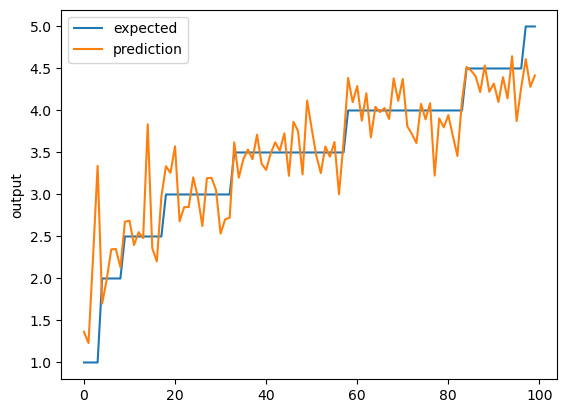

In [97]:
print("Final score (RMSE) of model 5:\t{}".format(score5))

chart_regression(bestpred.flatten()[0:100],y_test.to_numpy()[0:100], sort=True)

Based on our lift chart, this model is better at predicting values on the higher end of the scale and is less accurate when predicting values on the lower end of the scale.

Let's see the real value compared to the predicted value of our best model.

In [98]:
df_y = pd.DataFrame(y_test.to_numpy(), columns=['actual_stars'])
df_pred = pd.DataFrame(bestpred, columns=['predicted_stars'])
result = pd.concat([df_y, df_pred],axis=1)
result

,actual_stars,predicted_stars
0,3.0,3.198417
1,2.5,2.972735
2,3.0,2.533608
3,3.5,3.754695
4,3.5,3.222411
...,...,...
2381,3.5,3.878428
2382,3.5,2.667444
2383,4.5,4.315031
2384,2.0,1.308677


Let's choose 5 random businesses and see how they compare to the prediction of our best model.

In [121]:
import random
rand = random.randint(1,2385)

names = df_review_merged['name']

df_names = pd.DataFrame(names[rand-5:rand].to_numpy(), columns=['name'])
df_y = pd.DataFrame(y_test[rand-5:rand].to_numpy(), columns=['actual_stars'])
df_pred = pd.DataFrame(pred[rand-5:rand], columns=['predicted_stars'])
result = pd.concat([df_names, df_y, df_pred],axis=1)
result

,name,actual_stars,predicted_stars
0,China Panda,4.0,3.945644
1,Mac N Cheese After Dark,4.5,4.702247
2,Old Arabi Eats,3.5,3.568448
3,Three 12 Sport Bar and Lounge,2.0,2.118077
4,Pedalers Deli,3.0,3.388394


# Additional Features

Let's add the number of reviews into the model and see how it affects the accuracy.

In [100]:
featured_names = v_1500.get_feature_names_out()

x_data = matrix_1500.toarray()

funny_array = df_review_merged['funny'].values
funny_array.shape

useful_array = df_review_merged['useful'].values
useful_array.shape

cool_array = df_review_merged['cool'].values
cool_array.shape

review_count_array = df_review_merged['review_count'].values
review_count_array.shape

#Converting array into vertical stack
funny_array_vertical_review=np.vstack(funny_array)
useful_array_vertical_review=np.vstack(useful_array)
cool_array_vertical_review=np.vstack(cool_array)
review_count_vertical_review=np.vstack(review_count_array)
#Concatenating to make it all inputs in one array
x = np.concatenate((x_data, funny_array_vertical_review, useful_array_vertical_review, cool_array_vertical_review, review_count_vertical_review), axis=1)
print(x.shape)
print(x)

y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

(11927, 1504)
[[ 0.01607719  0.          0.         ... -0.21330168  0.01108753
  -0.39613299]
 [ 0.          0.          0.         ... -0.52804073 -0.4245671
  -0.41409454]
 [ 0.          0.00286787  0.0179273  ...  0.06795449 -0.25294558
   0.06488015]
 ...
 [ 0.04624286  0.          0.         ...  0.14161682 -0.35855882
  -0.43804328]
 [ 0.          0.03299562  0.         ... -0.17312223 -0.1869373
  -0.30632524]
 [ 0.          0.          0.         ... -0.51464758 -0.45097041
  -0.40810736]]


### Model #15 (Add total reviews to data)

In [101]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

extrapred = model.predict(x_test)

score15 = np.sqrt(metrics.mean_squared_error(extrapred, y_test))

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 6ms/step - loss: 1.2174 - val_loss: 0.6577
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.3222 - val_loss: 0.1867
Epoch 3/100
299/299 - 0s - 2ms/step - loss: 0.1537 - val_loss: 0.1737
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1357 - val_loss: 0.1702
Epoch 5/100
299/299 - 0s - 2ms/step - loss: 0.1257 - val_loss: 0.1700
Epoch 6/100
299/299 - 0s - 2ms/step - loss: 0.1185 - val_loss: 0.1688
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1131 - val_loss: 0.1720
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1088 - val_loss: 0.1703
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1030 - val_loss: 0.1723
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.0982 - val_loss: 0.1712
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.0937 - val_loss: 0.1711
Epoch 11: early stopping
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #16 (Add total reviews to data, change max features to 1000)

In [102]:
featured_names = v_1000.get_feature_names_out()

x_data = matrix_1000.toarray()

funny_array = df_review_merged['funny'].values
funny_array.shape

useful_array = df_review_merged['useful'].values
useful_array.shape

cool_array = df_review_merged['cool'].values
cool_array.shape

review_count_array = df_review_merged['review_count'].values
review_count_array.shape

#Converting array into vertical stack
funny_array_vertical_review=np.vstack(funny_array)
useful_array_vertical_review=np.vstack(useful_array)
cool_array_vertical_review=np.vstack(cool_array)
review_count_vertical_review=np.vstack(review_count_array)
#Concatenating to make it all inputs in one array
x = np.concatenate((x_data, funny_array_vertical_review, useful_array_vertical_review, cool_array_vertical_review, review_count_vertical_review), axis=1)
print(x.shape)
print(x)

y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

(11927, 1004)
[[ 0.01703163  0.          0.         ... -0.21330168  0.01108753
  -0.39613299]
 [ 0.          0.          0.         ... -0.52804073 -0.4245671
  -0.41409454]
 [ 0.          0.00297757  0.01861302 ...  0.06795449 -0.25294558
   0.06488015]
 ...
 [ 0.06741645  0.          0.         ...  0.14161682 -0.35855882
  -0.43804328]
 [ 0.          0.03405764  0.         ... -0.17312223 -0.1869373
  -0.30632524]
 [ 0.          0.          0.         ... -0.51464758 -0.45097041
  -0.40810736]]


In [103]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

pred = model.predict(x_test)

score16 = np.sqrt(metrics.mean_squared_error(pred, y_test))

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 5ms/step - loss: 0.9184 - val_loss: 0.2168
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1797 - val_loss: 0.1781
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1528 - val_loss: 0.1730
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1426 - val_loss: 0.1711
Epoch 5/100
299/299 - 0s - 1ms/step - loss: 0.1359 - val_loss: 0.1687
Epoch 6/100
299/299 - 0s - 1ms/step - loss: 0.1296 - val_loss: 0.1736
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1242 - val_loss: 0.1705
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1207 - val_loss: 0.1806
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1157 - val_loss: 0.1692
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1120 - val_loss: 0.1717
Epoch 10: early stopping
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Model #17 (Add total reviews to data, change max features to 500)

In [104]:
featured_names = v_500.get_feature_names_out()

x_data = matrix_500.toarray()
#print(x_data)
#print(featured_names)

funny_array = df_review_merged['funny'].values
funny_array.shape

useful_array = df_review_merged['useful'].values
useful_array.shape

cool_array = df_review_merged['cool'].values
cool_array.shape

review_count_array = df_review_merged['review_count'].values
review_count_array.shape

#Converting array into vertical stack
funny_array_vertical_review=np.vstack(funny_array)
useful_array_vertical_review=np.vstack(useful_array)
cool_array_vertical_review=np.vstack(cool_array)
review_count_vertical_review=np.vstack(review_count_array)
#Concatenating to make it all inputs in one array
x = np.concatenate((x_data, funny_array_vertical_review, useful_array_vertical_review, cool_array_vertical_review, review_count_vertical_review), axis=1)
print(x.shape)
print(x)

y = df_review_merged['stars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

(11927, 504)
[[ 0.          0.          0.         ... -0.21330168  0.01108753
  -0.39613299]
 [ 0.          0.          0.         ... -0.52804073 -0.4245671
  -0.41409454]
 [ 0.0053805   0.03197492  0.042989   ...  0.06795449 -0.25294558
   0.06488015]
 ...
 [ 0.          0.          0.         ...  0.14161682 -0.35855882
  -0.43804328]
 [ 0.03936097  0.          0.         ... -0.17312223 -0.1869373
  -0.30632524]
 [ 0.          0.          0.         ... -0.51464758 -0.45097041
  -0.40810736]]


In [105]:
model = Sequential()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(10, activation='tanh')) # Hidden 5
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="./dnn/best_weights.keras", verbose=0, save_best_only=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('./dnn/best_weights.keras')

pred = model.predict(x_test)

score17 = np.sqrt(metrics.mean_squared_error(pred, y_test))

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


299/299 - 2s - 8ms/step - loss: 1.0757 - val_loss: 0.2483
Epoch 2/100
299/299 - 0s - 1ms/step - loss: 0.1939 - val_loss: 0.1891
Epoch 3/100
299/299 - 0s - 1ms/step - loss: 0.1666 - val_loss: 0.1830
Epoch 4/100
299/299 - 0s - 1ms/step - loss: 0.1582 - val_loss: 0.1806
Epoch 5/100
299/299 - 0s - 971us/step - loss: 0.1530 - val_loss: 0.1810
Epoch 6/100
299/299 - 0s - 982us/step - loss: 0.1487 - val_loss: 0.1863
Epoch 7/100
299/299 - 0s - 1ms/step - loss: 0.1457 - val_loss: 0.1838
Epoch 8/100
299/299 - 0s - 1ms/step - loss: 0.1414 - val_loss: 0.1742
Epoch 9/100
299/299 - 0s - 1ms/step - loss: 0.1367 - val_loss: 0.1774
Epoch 10/100
299/299 - 0s - 1ms/step - loss: 0.1329 - val_loss: 0.1707
Epoch 11/100
299/299 - 0s - 1ms/step - loss: 0.1279 - val_loss: 0.1712
Epoch 12/100
299/299 - 0s - 1ms/step - loss: 0.1245 - val_loss: 0.1696
Epoch 13/100
299/299 - 0s - 1ms/step - loss: 0.1209 - val_loss: 0.1732
Epoch 14/100
299/299 - 0s - 1ms/step - loss: 0.1195 - val_loss: 0.1689
Epoch 15/100
299/299 - 

In [106]:
print("Current best model:")
print("Final score (RMSE) of model 5:\t{}".format(score5))
print("\n\n")
print("Final score (RMSE) of model 15:\t{}".format(score15))
print("Final score (RMSE) of model 16:\t{}".format(score16))
print("Final score (RMSE) of model 17:\t{}".format(score17))

Current best model:
Final score (RMSE) of model 5:	0.4092955274498892



Final score (RMSE) of model 15:	0.4108675196844437
Final score (RMSE) of model 16:	0.41072843178574364
Final score (RMSE) of model 17:	0.41099828453803816


None of these new models performed better than our current best model, model #5.